# Lesson 6: pets revisited

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [ ]:
bs = 64

In [ ]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [ ]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [ ]:
def get_data(size,bs,padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [ ]:
data = get_data(224,bs,'zeros')

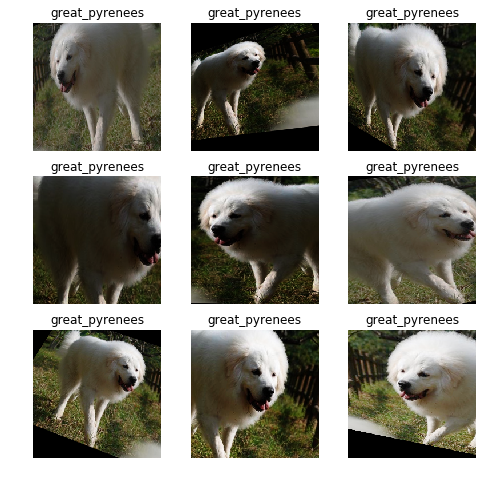

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
data = get_data(224,bs)

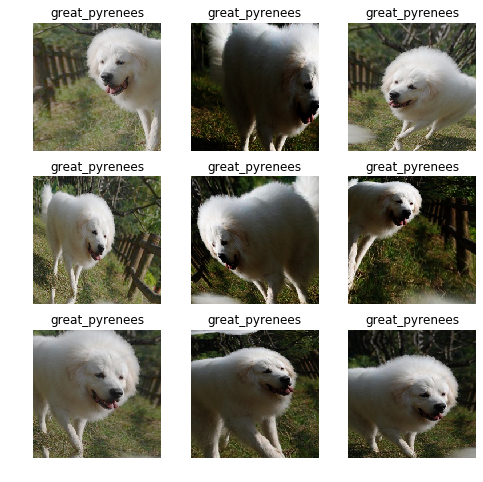

In [ ]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [ ]:
gc.collect()
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

Total time: 00:52
epoch  train_loss  valid_loss  error_rate
1      2.413196    1.091087    0.191475    (00:18)
2      1.397552    0.331309    0.081867    (00:17)
3      0.889401    0.269724    0.068336    (00:17)



In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

Total time: 00:44
epoch  train_loss  valid_loss  error_rate
1      0.695697    0.286645    0.064276    (00:22)
2      0.636241    0.295290    0.066982    (00:21)



In [ ]:
data = get_data(352,bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:32
epoch  train_loss  valid_loss  error_rate
1      0.626780    0.264292    0.056834    (00:47)
2      0.585733    0.261575    0.048038    (00:45)



In [ ]:
learn.save('352')

## Heatmap

In [ ]:
data = get_data(352,16)
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Maine_Coon

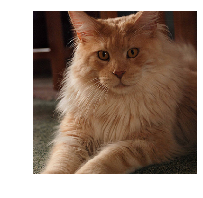

In [ ]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

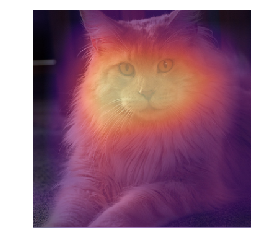

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

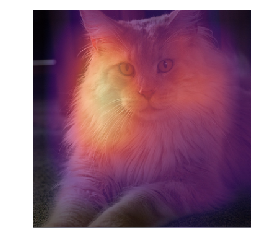

In [ ]:
show_heatmap(mult)

In [ ]:
fn = path/'../other/bulldog_maine.jpg'

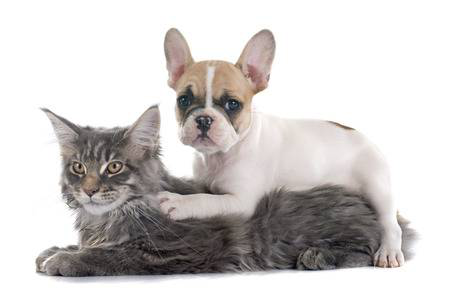

In [ ]:
x = open_image(fn); x

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

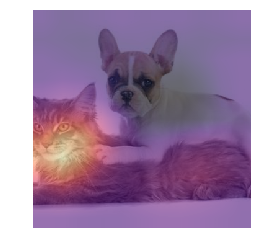

In [ ]:
show_heatmap(mult)

In [ ]:
data.classes[0]

'american_bulldog'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

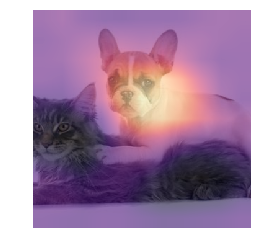

In [ ]:
show_heatmap(mult)

## fin